In [18]:
from scripts.analyze_embeddings import *
import os
import pickle
import torch as t
from model import Word2Vec, SGNS
import math

In [19]:
run_path = "runs/T512-train-window-10-coord-weights-saveall"

In [20]:
# Load BOTH input and output embeddings
idx2ivec_path = f"{run_path}/idx2ivec.dat"
idx2ovec_path = f"{run_path}/idx2ovec.dat"

idx2ivec = pickle.load(open(idx2ivec_path, 'rb'))
idx2ovec = pickle.load(open(idx2ovec_path, 'rb'))

print(f"Loaded idx2ivec (input vectors) with {len(idx2ivec)} embeddings")
print(f"Loaded idx2ovec (output vectors) with {len(idx2ovec)} embeddings")
print(f"Embedding dimension: {idx2ivec[0].shape if len(idx2ivec) > 0 else 'N/A'}")

# Note: idx2ivec and idx2ovec are indexed by word index
# We'll create word2embed dicts after loading idx2word

Loaded idx2ivec (input vectors) with 50304 embeddings
Loaded idx2ovec (output vectors) with 50304 embeddings
Embedding dimension: (512,)


In [21]:
# Configuration
data_dir = "/cache/openwebtext/train"  # Update this to your data directory
model_path = "runs/T512-train-window-10-coord-weights/sgns.pt"  # Update to your model path
e_dim = 512  # Embedding dimension

# Load vocab
words = pickle.load(open(os.path.join(data_dir, 'idx2word.dat'), 'rb'))
vocab_size = len(words)
print(f"Vocab size: {vocab_size}")
print(words)

# Create word-to-embedding dictionaries for BOTH input and output vectors
ivec_embeds = {words[idx]: idx2ivec[idx] for idx in range(len(words))}
ovec_embeds = {words[idx]: idx2ovec[idx] for idx in range(len(words))}
print(f"Created ivec_embeds dict with {len(ivec_embeds)} entries")
print(f"Created ovec_embeds dict with {len(ovec_embeds)} entries")

Vocab size: 50304
['<UNK>', 'the', 'to', 'of', 'and', 'a', 'in', 'that', 'is', 'for', 'on', 'with', 'was', 'The', 'as', 'it', 'be', 'are', 'I', 'have', 'at', 'by', 'from', 'this', 'you', 'not', 'an', 'he', 'has', 'his', 'or', 'but', 'will', 'they', 'their', 'we', 'more', 'who', 'about', 'can', 'were', 'had', 'which', 'been', 'would', 'one', 'all', 'said', 'out', 'up', 'also', 'when', 'In', 'than', 'its', 'your', 'like', 'what', 'if', 'into', 'so', 'just', 'other', 'some', 'people', 'our', 'her', 'my', 'do', 'no', 'only', 'new', 'there', 'It', 'after', 'first', 'could', 'over', 'But', 'This', '–', 'get', 'two', 'she', 'how', 'He', 'time', '—', 'because', 'them', 'most', 'any', 'A', 'even', 'these', 'make', '-', 'being', 'where', 'many', 'And', 'those', 'very', 'last', 'him', 'said.', 'then', 'much', 'should', 'now', 'may', 'such', 'see', 'through', 'made', 'back', 'going', 'against', 'think', 'We', 'way', 'before', 'me', 'If', 'still', 'use', 'while', 'years', 'between', 'know', 'want',

In [22]:
words.count('the')

1

In [23]:
# Load model to get coord_weights
print(f"Loading model from {model_path}...")
model = Word2Vec(vocab_size=vocab_size, embedding_size=e_dim, torus=True)
sgns = SGNS(embedding=model, vocab_size=vocab_size, n_negs=20, torus=True)
sgns.load_state_dict(t.load(model_path, map_location='cpu'))

if not hasattr(sgns, 'coord_weights'):
    print("Error: Model does not have coord_weights. Make sure it's a toric model.")
else:
    coord_weights = sgns.coord_weights
    print(f"Loaded coord_weights: shape={coord_weights.shape}, mean={coord_weights.mean().item():.4f}")


Loading model from runs/T512-train-window-10-coord-weights/sgns.pt...


Loaded coord_weights: shape=torch.Size([512]), mean=0.0279


In [24]:
# Summary
print(f"\nSummary:")
print(f"  Loaded {len(idx2ivec)} word embeddings from idx2vec.dat")
print(f"  Loaded {len(idx2ovec)} word embeddings from idx2ovec.dat")
print(f"  Created word-to-embedding dict with {len(ivec_embeds)} entries")
print(f"  Embedding dimension: {len(list(ivec_embeds.values())[0])}")
print(f"  Vocab size: {vocab_size}")
print(f"  Coord weights available: {coord_weights is not None if 'coord_weights' in locals() else False}")



Summary:
  Loaded 50304 word embeddings from idx2vec.dat
  Loaded 50304 word embeddings from idx2ovec.dat
  Created word-to-embedding dict with 50304 entries
  Embedding dimension: 512
  Vocab size: 50304
  Coord weights available: True


In [25]:
device = t.device('cuda' if t.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if t.cuda.is_available():
    print(f"GPU: {t.cuda.get_device_name(0)}")
    
    # Move embeddings to GPU
    idx2ivec = t.tensor(idx2ivec, device=device, dtype=t.float32)
    idx2ovec = t.tensor(idx2ovec, device=device, dtype=t.float32)
    
    # Move coord_weights to GPU
    coord_weights = coord_weights.to(device)
    
    # Update the dictionaries to use GPU tensors
    word2ivec = {words[idx]: idx2ivec[idx] for idx in range(len(words))}
    word2ovec = {words[idx]: idx2ovec[idx] for idx in range(len(words))}
    
    print("Moved embeddings to GPU!")
else:
    print("No GPU available, using CPU")

Using device: cuda
GPU: NVIDIA H100 80GB HBM3
Moved embeddings to GPU!


Man woman king queen analysis

In [26]:
man = word2ivec['man']
min(man), max(man)

(tensor(-2.7106, device='cuda:0'), tensor(2.2054, device='cuda:0'))

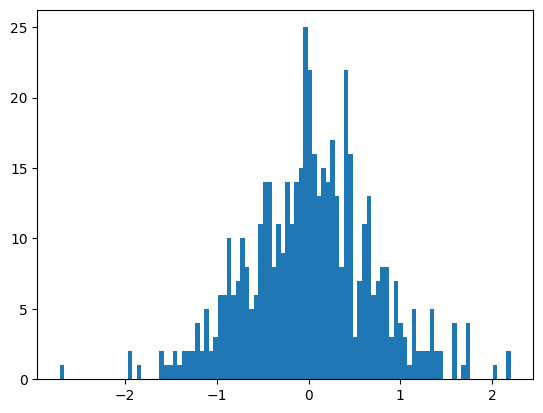

In [27]:
# histogram of man
plt.hist(man.cpu(), bins=100)
plt.show()

In [28]:
len(ivec_embeds)

50304

Min coord_weight: -0.181292 at index 20
Max coord_weight: 1.692670 at index 486
Mean: 0.027861, Std: 0.092058


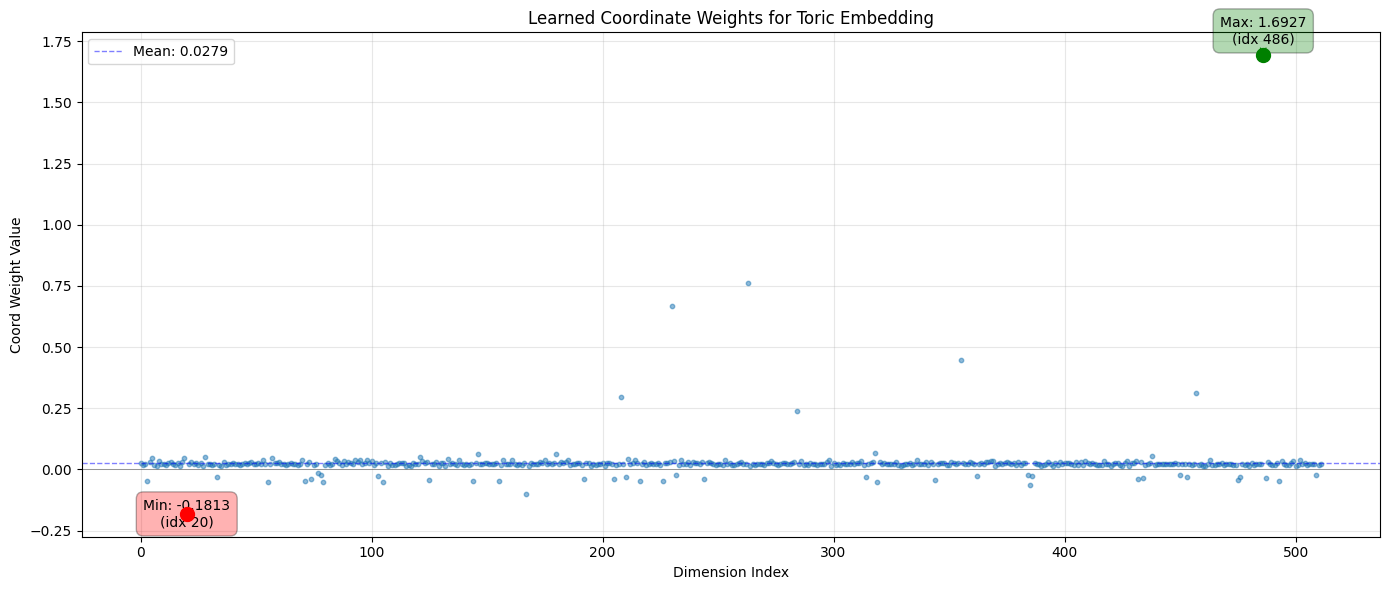

In [29]:
# Plot coord_weights as scatter plot, annotate min max
weights_np = coord_weights.detach().cpu().numpy()
indices = np.arange(len(weights_np))

# Find min and max
min_idx = np.argmin(weights_np)
max_idx = np.argmax(weights_np)
min_val = weights_np[min_idx]
max_val = weights_np[max_idx]

print(f"Min coord_weight: {min_val:.6f} at index {min_idx}")
print(f"Max coord_weight: {max_val:.6f} at index {max_idx}")
print(f"Mean: {weights_np.mean():.6f}, Std: {weights_np.std():.6f}")

plt.figure(figsize=(14, 6))
plt.scatter(indices, weights_np, alpha=0.5, s=10)

# Annotate min
plt.scatter(min_idx, min_val, color='red', s=100, zorder=5)
plt.annotate(f'Min: {min_val:.4f}\n(idx {min_idx})', 
             xy=(min_idx, min_val), 
             xytext=(min_idx, min_val - 0.05),
             ha='center',
             fontsize=10,
             bbox=dict(boxstyle='round,pad=0.5', facecolor='red', alpha=0.3),
             arrowprops=dict(arrowstyle='->', color='red'))

# Annotate max
plt.scatter(max_idx, max_val, color='green', s=100, zorder=5)
plt.annotate(f'Max: {max_val:.4f}\n(idx {max_idx})', 
             xy=(max_idx, max_val), 
             xytext=(max_idx, max_val + 0.05),
             ha='center',
             fontsize=10,
             bbox=dict(boxstyle='round,pad=0.5', facecolor='green', alpha=0.3),
             arrowprops=dict(arrowstyle='->', color='green'))

plt.axhline(y=0, color='k', linestyle='-', linewidth=0.5, alpha=0.5)
plt.axhline(y=weights_np.mean(), color='blue', linestyle='--', linewidth=1, alpha=0.5, label=f'Mean: {weights_np.mean():.4f}')
plt.xlabel('Dimension Index')
plt.ylabel('Coord Weight Value')
plt.title('Learned Coordinate Weights for Toric Embedding')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [33]:
def sum_cosine_diff(word1: int|str|t.Tensor, word2: int|str|t.Tensor, coord_weights=coord_weights):
    if isinstance(word1, int):
        ivec = t.tensor(idx2ivec[word1])
    elif isinstance(word1, str):
        ivec = word2ivec[word1]
    else:
        ivec = word1

    if isinstance(word2, int):
        ovec = t.tensor(idx2ovec[word2])
    elif isinstance(word2, str):
        ovec = word2ovec[word2]
    else:
        ovec = word2
        
    return (coord_weights * t.cos(t.pi * (ivec - ovec))).sum(dim=-1)

def batch_sum_cosine_diff(word1_idx: [int|str], word2_idx: [int|str], coord_weights=coord_weights):
    """
    Compute proper toric similarity for skip-gram:
    h(word1, word2) = sum(coord_weights * cos(π * (ivec[word1] - ovec[word2])))
    
    """
    if isinstance(word1_idx[0], str):
        word1_idx = [words.index(word) for word in word1_idx]
    if isinstance(word2_idx[0], str):
        word2_idx = [words.index(word) for word in word2_idx]
    ivecs = t.stack([t.tensor(idx2ivec[word]) for word in word1_idx])
    ovecs = t.stack([t.tensor(idx2ovec[word]) for word in word2_idx])
    return (coord_weights * t.cos(t.pi * (ivecs - ovecs))).sum(dim=-1)

In [34]:
def get_closest_words(word: int|str|t.Tensor, ovec=True, n=10):
    if isinstance(word, int):
        if ovec:
            word = t.tensor(idx2ovec[word])
        else:
            word = t.tensor(idx2ivec[word])
    elif isinstance(word, str):
        if ovec:
            word = word2ovec[word]
        else:
            word = word2ivec[word]
    sim = []
    for context_idx in range(len(ovec_embeds)):
        h = (sum_cosine_diff(word, context_idx) if ovec else sum_cosine_diff(context_idx, word)).item()
        sim.append((h, words[context_idx]))
    sim = sorted(sim, reverse=True)
    return sim[:n]

In [35]:
print(f"get_closest_words('man', 10): {get_closest_words('man', 10)}")
print(f"get_closest_words('woman', 10): {get_closest_words('woman', 10)}")
print(f"get_closest_words('king', 10): {get_closest_words('king', 10)}")
print(f"get_closest_words('queen', 10): {get_closest_words('queen', 10)}")

/tmp/ipykernel_1487008/353932748.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ovec = t.tensor(idx2ovec[word2])


get_closest_words('man', 10): [(14.264616966247559, 'man'), (8.630928039550781, 'woman'), (8.13424015045166, 'man,'), (7.07012939453125, 'cop'), (7.006649971008301, 'mother'), (6.96759033203125, 'cops'), (6.872025489807129, 'woman,'), (6.826591968536377, 'suspect,'), (6.796997547149658, 'man.'), (6.791416168212891, 'person')]
get_closest_words('woman', 10): [(14.264616966247559, 'woman'), (10.510074615478516, 'woman,'), (9.001983642578125, 'girl'), (8.931458473205566, 'woman.'), (8.630928039550781, 'man'), (8.594992637634277, 'boy'), (8.39126968383789, 'girl,'), (8.342596054077148, 'lady'), (8.253469467163086, 'actress'), (8.189455032348633, 'prostitute')]
get_closest_words('king', 10): [(14.264616966247559, 'king'), (8.551473617553711, 'prince'), (8.214996337890625, 'Emperor'), (7.997950553894043, 'king,'), (7.961764812469482, 'throne'), (7.717988967895508, 'kingdom'), (7.614745140075684, 'monarch'), (7.575709342956543, 'emperor'), (7.3675642013549805, 'kings'), (7.323871612548828, 'L

Selected 4 words: ['man', 'woman', 'king', 'queen']
Embeddings shape: (4, 512)
Torus projection shape: (4, 1024)
PCA reduced shape: (4, 2)


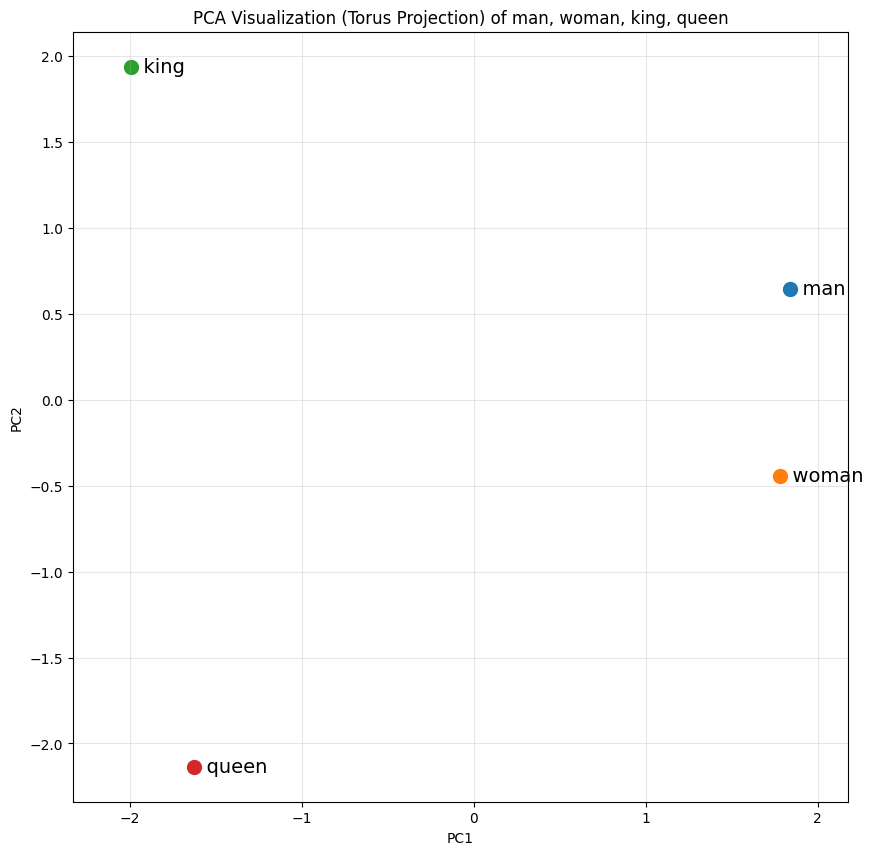

In [ ]:
# Mini experiment: visualize just man, woman, king, queen
# Import torus_projection from plot_torus
import sys
sys.path.insert(0, '.')
from plot_torus import torus_projection
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Select the 4 words
target_words = ['man', 'woman', 'king', 'queen']
X_mini = np.array([word2ivec[word].cpu() for word in target_words])
print(f"Selected {len(target_words)} words: {target_words}")
print(f"Embeddings shape: {X_mini.shape}")

# Apply torus projection with coord_weights
coord_weights_np = coord_weights.detach().cpu().numpy()
X_torus_mini = torus_projection(X_mini, 'pca', coord_weights=coord_weights_np)
print(f"Torus projection shape: {X_torus_mini.shape}")

# Apply PCA to reduce to 2D
pca = PCA(n_components=2)
X_reduced_mini = pca.fit_transform(X_torus_mini)
print(f"PCA reduced shape: {X_reduced_mini.shape}")

# Plot
plt.figure(figsize=(10, 10))
for i, word in enumerate(target_words):
    plt.scatter(X_reduced_mini[i, 0], X_reduced_mini[i, 1], s=100)
    plt.text(X_reduced_mini[i, 0], X_reduced_mini[i, 1], f'  {word}', 
             fontsize=14, ha='left', va='center')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Visualization (Torus Projection) of man, woman, king, queen')
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.show()


Selected 9 words: ['man', 'woman', 'king', 'queen', 'boy', 'girl', 'prince', 'princess', 'emperor']


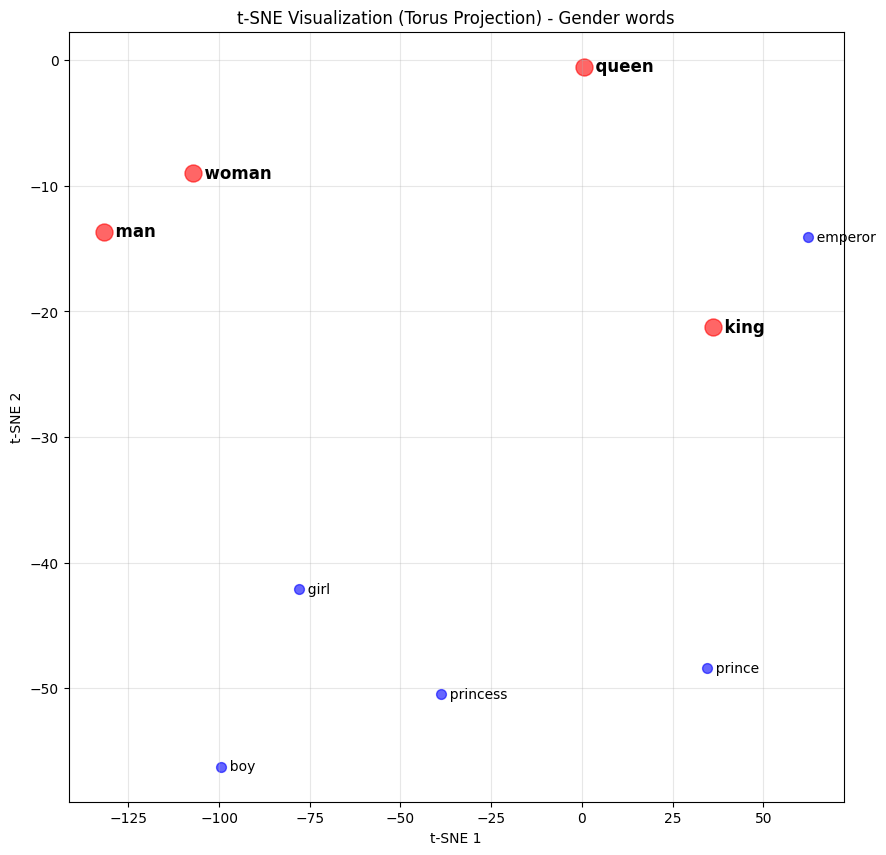

In [ ]:
# Same experiment with t-SNE (note: t-SNE needs at least 4 points, so this is minimal)
# For better t-SNE, include more words
extra_words = ['boy', 'girl', 'prince', 'princess', 'emperor', 'empress']
all_words = target_words + extra_words
X_mini_extended = np.array([word2ivec[word].cpu() for word in all_words if word in word2ivec])
actual_words = [word for word in all_words if word in word2ivec]

print(f"Selected {len(actual_words)} words: {actual_words}")

# Apply torus projection
X_torus_extended = torus_projection(X_mini_extended, 'tsne', coord_weights=coord_weights_np)

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=min(3, len(actual_words)-1), init='pca', random_state=42)
X_reduced_tsne = tsne.fit_transform(X_torus_extended)

# Plot
plt.figure(figsize=(10, 10))
for i, word in enumerate(actual_words):
    color = 'red' if word in target_words else 'blue'
    size = 150 if word in target_words else 50
    plt.scatter(X_reduced_tsne[i, 0], X_reduced_tsne[i, 1], s=size, c=color, alpha=0.6)
    plt.text(X_reduced_tsne[i, 0], X_reduced_tsne[i, 1], f'  {word}', 
             fontsize=12 if word in target_words else 10, 
             ha='left', va='center',
             weight='bold' if word in target_words else 'normal')

plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE Visualization (Torus Projection) - Gender words')
plt.grid(True, alpha=0.3)
plt.show()


Selected top 20000 words for t-SNE computation
Embeddings shape: (20000, 512)
Torus projection shape: (20000, 1024)
t-SNE completed! Shape: (20000, 2)
Found 'man' at index 278
Found 'woman' at index 662
Found 'king' at index 5841
Found 'queen' at index 13299


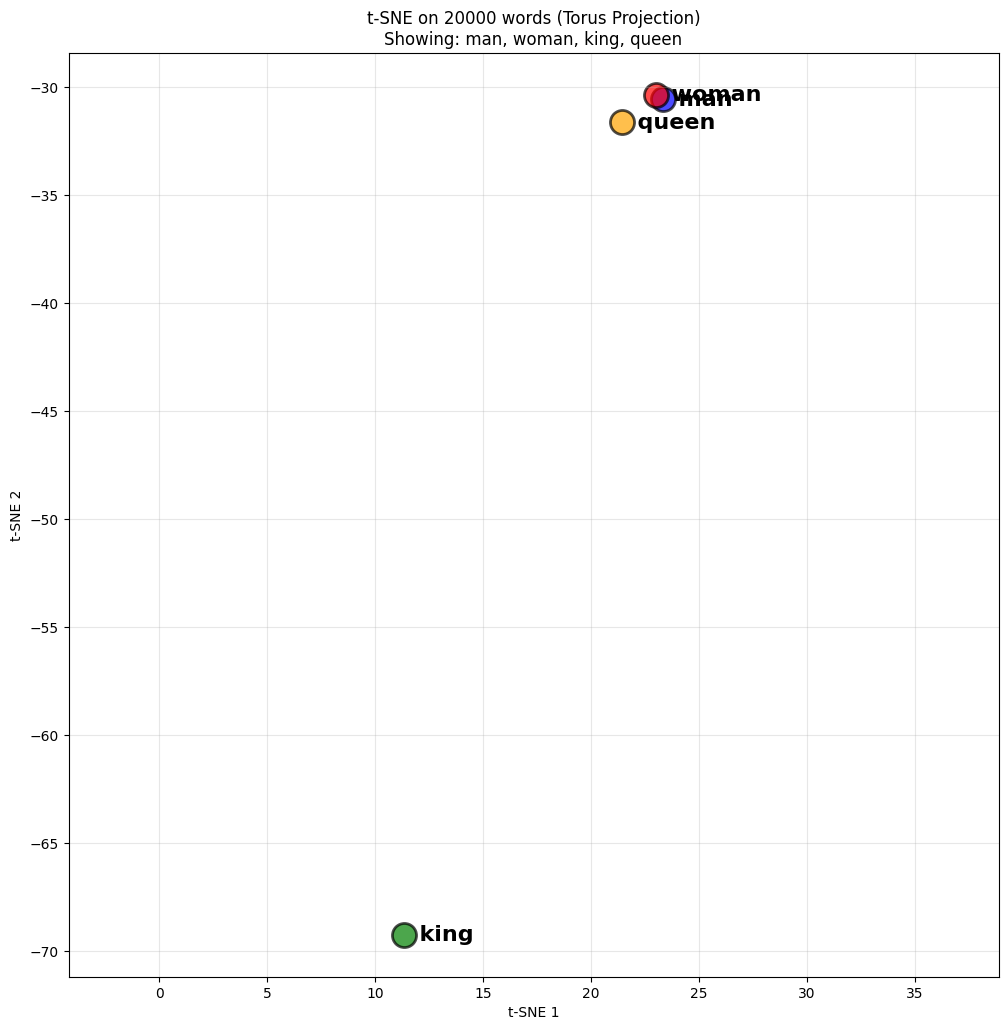


Pairwise Euclidean distances in t-SNE space:
  man <-> woman: 0.4044
  man <-> king: 40.5111
  man <-> queen: 2.1727
  woman <-> king: 40.6194
  woman <-> queen: 2.0139
  king <-> queen: 38.9605


In [ ]:
# Compute t-SNE on 1000 points, but only visualize man, woman, king, queen
# Get top 1000 most frequent words
wc_path = os.path.join(data_dir, 'wc.dat')
wc = pickle.load(open(wc_path, 'rb'))
sorted_words = sorted(wc, key=wc.get, reverse=True)
k = 20000
top_k_words = sorted_words[:k]

print(f"Selected top {k} words for t-SNE computation")

# Get embeddings for all k words
top_k_embeds = np.array([ivec_embeds[word] for word in top_k_words])
print(f"Embeddings shape: {top_k_embeds.shape}")

# Apply torus projection
X_torus_k = torus_projection(top_k_embeds, 'tsne', coord_weights=coord_weights_np)
print(f"Torus projection shape: {X_torus_k.shape}")

# Run t-SNE on all k points
tsne_k = TSNE(n_components=2, perplexity=30, init='pca', random_state=42)
X_reduced_k = tsne_k.fit_transform(X_torus_k)
print(f"t-SNE completed! Shape: {X_reduced_k.shape}")

# Find indices of our target words in the k words
target_words = ['man', 'woman', 'king', 'queen']
target_indices = []
for word in target_words:
    if word in top_k_words:
        idx = top_k_words.index(word)
        target_indices.append((idx, word))
        print(f"Found '{word}' at index {idx}")
    else:
        print(f"Warning: '{word}' not in top {k}")

# Plot only the 4 target words
plt.figure(figsize=(12, 12))
colors = {'man': 'blue', 'woman': 'red', 'king': 'green', 'queen': 'orange'}

for idx, word in target_indices:
    x, y = X_reduced_k[idx, 0], X_reduced_k[idx, 1]
    plt.scatter(x, y, s=300, c=colors[word], alpha=0.7, edgecolors='black', linewidth=2)
    plt.text(x, y, f'  {word}', fontsize=16, ha='left', va='center', weight='bold')

plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title(f't-SNE on {k} words (Torus Projection)\nShowing: man, woman, king, queen')
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.show()

# Print distances between the words
print("\nPairwise Euclidean distances in t-SNE space:")
for i, (idx1, word1) in enumerate(target_indices):
    for idx2, word2 in target_indices[i+1:]:
        dist = np.linalg.norm([X_reduced_k[idx1] - X_reduced_k[idx2]])
        print(f"  {word1} <-> {word2}: {dist:.4f}")


In [ ]:
print(f"man_to_woman: {sum_cosine_diff('man', 'woman')}")
print(f"king_to_queen: {sum_cosine_diff('king', 'queen')}")
print(f"man_to_king: {sum_cosine_diff('man', 'king')}")
print(f"woman_to_queen: {sum_cosine_diff('woman', 'queen')}")
# man to uncle
print(f"man_to_uncle: {sum_cosine_diff('man', 'uncle')}")
# woman to aunt
print(f"woman_to_aunt: {sum_cosine_diff('woman', 'aunt')}")

# man to father
print(f"man_to_father: {sum_cosine_diff('man', 'father')}")
# woman to mother
print(f"woman_to_mother: {sum_cosine_diff('woman', 'mother')}")

# man to dad
print(f"man_to_dad: {sum_cosine_diff('man', 'dad')}")
# woman to mom
print(f"woman_to_mom: {sum_cosine_diff('woman', 'mom')}")

# man to son
print(f"man_to_son: {sum_cosine_diff('man', 'son')}")
# woman to daughter
print(f"woman_to_daughter: {sum_cosine_diff('woman', 'daughter')}")

# man to brother
print(f"man_to_brother: {sum_cosine_diff('man', 'brother')}")
# woman to sister
print(f"woman_to_sister: {sum_cosine_diff('woman', 'sister')}")


man_to_woman: -0.41167378425598145
king_to_queen: -0.02205336093902588
man_to_king: -2.681514263153076
woman_to_queen: -2.0697882175445557
man_to_uncle: -3.2445967197418213
woman_to_aunt: -3.0799925327301025
man_to_father: -2.2727885246276855
woman_to_mother: -1.589762806892395
man_to_dad: -3.19677472114563
woman_to_mom: -3.008065700531006
man_to_son: -2.3850743770599365
woman_to_daughter: -1.617828130722046
man_to_brother: -2.4838051795959473
woman_to_sister: -2.2526774406433105


/tmp/ipykernel_1198882/798041297.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ivec = t.tensor(idx2ivec[word1_idx])
/tmp/ipykernel_1198882/798041297.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ovec = t.tensor(idx2ovec[word2_idx])


In [ ]:
print(f"man_to_woman: {sum_cosine_diff('man', 'woman')}")
print(f"king_to_queen: {sum_cosine_diff('king', 'queen')}")
print(f"dad_to_mom: {sum_cosine_diff('dad', 'mom')}")
print(f"son_to_daughter: {sum_cosine_diff('son', 'daughter')}")
print(f"brother_to_sister: {sum_cosine_diff('brother', 'sister')}")
print(f"boy_to_girl: {sum_cosine_diff('boy', 'girl')}")
print(f"boyfriend_to_girlfriend: {sum_cosine_diff('boyfriend', 'girlfriend')}")
print(f"husband_to_wife: {sum_cosine_diff('husband', 'wife')}")

man_to_woman: -0.41167378425598145
king_to_queen: -0.02205336093902588
dad_to_mom: 0.7066408395767212
son_to_daughter: -0.42136049270629883
brother_to_sister: 0.399821400642395
boy_to_girl: 0.32698655128479004
boyfriend_to_girlfriend: -0.4049302339553833
husband_to_wife: 0.2764078378677368


/tmp/ipykernel_1198882/798041297.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ivec = t.tensor(idx2ivec[word1_idx])
/tmp/ipykernel_1198882/798041297.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ovec = t.tensor(idx2ovec[word2_idx])


In [ ]:
sim = [(sum_cosine_diff(word, 'man'), word) for word in words]
sim = sorted(sim, key=lambda x: x[0], reverse=True)
sim[:10]

/tmp/ipykernel_1198882/798041297.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ivec = t.tensor(idx2ivec[word1_idx])
/tmp/ipykernel_1198882/798041297.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ovec = t.tensor(idx2ovec[word2_idx])


[(tensor(0.9213, device='cuda:0', grad_fn=<SumBackward1>), '40-year-old'),
 (tensor(0.8887, device='cuda:0', grad_fn=<SumBackward1>), '25-year-old'),
 (tensor(0.8353, device='cuda:0', grad_fn=<SumBackward1>), 'fatally'),
 (tensor(0.7903, device='cuda:0', grad_fn=<SumBackward1>), '37-year-old'),
 (tensor(0.7626, device='cuda:0', grad_fn=<SumBackward1>), '45-year-old'),
 (tensor(0.7048, device='cuda:0', grad_fn=<SumBackward1>), '23-year-old'),
 (tensor(0.5941, device='cuda:0', grad_fn=<SumBackward1>), '43-year-old'),
 (tensor(0.5843, device='cuda:0', grad_fn=<SumBackward1>), '26-year-old'),
 (tensor(0.5838, device='cuda:0', grad_fn=<SumBackward1>), '32-year-old'),
 (tensor(0.5723, device='cuda:0', grad_fn=<SumBackward1>), 'molesting')]

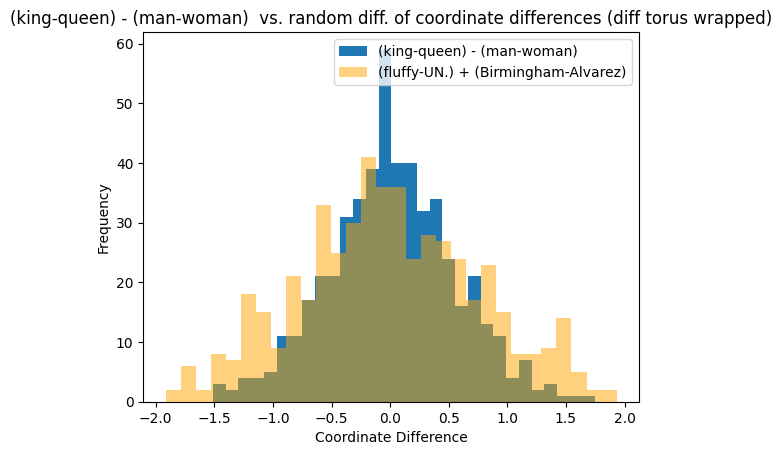

In [ ]:
# hypothesis: ivec['king'] - ivec['queen'] = ivec['man'] - ivec['woman']
q2k = word2ivec['king'] - word2ivec['queen']
q2k = (q2k.cpu().numpy() + 1)%2 - 1
w2m = word2ivec['man'] - word2ivec['woman']
w2m = (w2m.cpu().numpy() + 1)%2 - 1
diff = q2k - w2m
plt.hist(diff, bins=30, label='(king-queen) - (man-woman)')


# compare to random ivec[w1] + ivec[w2] - ivec[w3] - ivec[w4]
w1 = np.random.choice(words)
w2 = np.random.choice(words)
w3 = np.random.choice(words)
w4 = np.random.choice(words)
w1_w2 = word2ivec[w1] - word2ivec[w2]
w1_w2 = (w1_w2.cpu().numpy() + 1)%2 - 1
w3_w4 = word2ivec[w3] - word2ivec[w4]
w3_w4 = (w3_w4.cpu().numpy() + 1)%2 - 1
rand_diff = w1_w2 - w3_w4
plt.hist(rand_diff, bins=30, color='orange', alpha=0.5, label=f'({w1}-{w2}) + ({w3}-{w4})') # red histogram, more transparent

plt.ylabel('Frequency')
plt.xlabel('Coordinate Difference')
plt.legend()
plt.title('(king-queen) - (man-woman)  vs. random diff. of coordinate differences (diff torus wrapped)')
plt.show()

In [ ]:
diffs = []
for o_word in words:
    k_q = sum_cosine_diff("king", o_word) - sum_cosine_diff("queen", o_word)
    m_w = sum_cosine_diff("man", o_word) - sum_cosine_diff("woman", o_word)
    diffs.append((k_q-m_w).cpu().item())
plt.hist(diffs, bins=100)
plt.show()

/tmp/ipykernel_1198882/798041297.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ivec = t.tensor(idx2ivec[word1_idx])
/tmp/ipykernel_1198882/798041297.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ovec = t.tensor(idx2ovec[word2_idx])


KeyboardInterrupt: 

Check log h ~ PMI

In [ ]:
# Compute e^(ln k + PMI(c,w)) vs. h(w,c) for skip-gram pairs
# where PMI(w,c) = log p(c,w)/(p_c * p_w)
# and h(w,c) is the toric similarity

# Load word counts to get marginal probabilities
wc_path = os.path.join(data_dir, 'wc.dat')
wc = pickle.load(open(wc_path, 'rb'))

# Compute total word count
total_words = sum(wc.values())
print(f"Total word count: {total_words:,}")

# Load training data to get co-occurrence counts
train_path = os.path.join(data_dir, 'train.dat')
print(f"Loading training pairs from {train_path}...")
train_data = pickle.load(open(train_path, 'rb'))
print(f"Loaded {len(train_data):,} skip-gram pairs")

Total word count: 6,548,285,048
Loading training pairs from /cache/openwebtext/train/train.dat...
Loaded 829,484,499 skip-gram pairs


In [ ]:
# Sample pairs to make computation tractable
sample_size = min(10_000_000, len(train_data))
import random
random.seed(42)
sampled_indices = random.sample(range(len(train_data)), sample_size)
print(f"Using {sample_size:,} sampled pairs for analysis")


Using 10,000,000 sampled pairs for analysis


In [ ]:
wc['man']

dict

In [ ]:
# The pairs are already in train.dat - each occurrence represents a co-occurrence
# For PMI estimation, we'll use the full train_data length for normalization
from collections import Counter

# Count occurrences in our sample for validation
sample_pair_counts = Counter()
sample_center_counts = Counter()
sample_context_counts = Counter()
for data_idx in sampled_indices:
    center_idx, context_indices = train_data[data_idx]
    sample_center_counts[center_idx] += 1
    for context_idx in context_indices:
        sample_pair_counts[(center_idx, context_idx)] += 1
        sample_context_counts[context_idx] += 1

print(f"Sampled {len(sample_pair_counts):,} unique pairs")

# Total pairs in full dataset (each entry in train_data has multiple contexts)
num_context_words = 10
total_pairs_in_data = len(train_data) * num_context_words
print(f"Estimated total co-occurrence pairs in train.dat: {total_pairs_in_data:,.0f}")
print(f"Average contexts per center word: {num_context_words:.2f}")

Sampled 20,188,508 unique pairs
Estimated total co-occurrence pairs in train.dat: 8,294,844,990
Average contexts per center word: 10.00


In [ ]:
sample_pair_counts

Counter({(0, 0): 510861,
         (1, 0): 124855,
         (0, 1): 78722,
         (3, 0): 65386,
         (4, 0): 60598,
         (2, 0): 56541,
         (5, 0): 53348,
         (0, 4): 45122,
         (6, 0): 43167,
         (0, 3): 42522,
         (1, 3): 40948,
         (3, 1): 40939,
         (1, 1): 39069,
         (0, 2): 36414,
         (13, 0): 35391,
         (0, 5): 35262,
         (8, 0): 29401,
         (0, 6): 27558,
         (2, 1): 26714,
         (1, 2): 26490,
         (1, 4): 22748,
         (4, 1): 22684,
         (9, 0): 22334,
         (1, 6): 21247,
         (6, 1): 21161,
         (7, 0): 20290,
         (10, 0): 19422,
         (0, 8): 16943,
         (11, 0): 16889,
         (12, 0): 16791,
         (0, 7): 14053,
         (0, 9): 13996,
         (14, 0): 13797,
         (1, 5): 12916,
         (5, 3): 12914,
         (5, 1): 12899,
         (3, 5): 12893,
         (21, 0): 12335,
         (17, 0): 12198,
         (0, 11): 11943,
         (20, 0): 11787,
     

In [ ]:
# Compute PMI and toric similarity for sampled pairs (VECTORIZED - much faster!)
# Use population estimates from full corpus (wc) not sample
k = 20  # Number of negative samples in SGNS

print("Preparing data for vectorized computation...")
unique_pairs = list(sample_pair_counts.items())

# Pre-filter pairs to only those in vocabulary AND word count dict
valid_pairs_data = []
for (center_idx, context_idx), count_pair in unique_pairs:
    center_word = words[center_idx]
    context_word = words[context_idx]
    # Check embeddings exist AND words are in word count dict (to avoid missing counts)
    if (center_word in ivec_embeds and context_word in ovec_embeds and 
        center_word in wc and context_word in wc):
        valid_pairs_data.append((center_idx, context_idx, center_word, context_word, count_pair))

print(f"Found {len(valid_pairs_data):,} valid pairs in vocabulary with word counts")

# Vectorized PMI computation
print("Computing PMI values (vectorized)...")
center_indices, context_indices, center_words, context_words, count_pairs = zip(*valid_pairs_data)

# Get population counts (vectorized) - all words guaranteed to be in wc now
count_w_array = t.tensor([wc[w] for w in center_words])
count_c_array = t.tensor([wc[w] for w in context_words])
count_pair_array = t.tensor(count_pairs)

# Compute probabilities
p_w_array = count_w_array / total_words
p_c_array = count_c_array / total_words
p_wc_array = count_pair_array / t.sum(count_pair_array)

# Compute PMI (vectorized)
pmi_values = t.log((p_wc_array + 1e-11) / (p_w_array * p_c_array + 1e-11))

Preparing data for vectorized computation...
Found 20,188,508 valid pairs in vocabulary with word counts
Computing PMI values (vectorized)...


In [ ]:
pmi_values.shape

torch.Size([20188508])

In [ ]:
pmi_values[:5]

tensor([18.2483,  0.4463, -0.3110,  0.3337,  1.0636])

In [ ]:
# Vectorized toric similarity computation (MUCH faster!)
print("Computing toric similarities (vectorized batches)...")
batch_size = 100000  # Process in batches to avoid memory issues
toric_sim_values = []

device = t.device('cuda' if t.cuda.is_available() else 'cpu')
coord_weights = coord_weights.to(device)

for i in range(0, len(valid_pairs_data), batch_size):
    batch_end = min(i + batch_size, len(valid_pairs_data))
    batch_center = center_words[i:batch_end]
    batch_context = context_words[i:batch_end]
    
    # Stack embeddings for batch computation
    ivecs = t.stack([t.tensor(ivec_embeds[w]) for w in batch_center]).to(device)
    ovecs = t.stack([t.tensor(ovec_embeds[w]) for w in batch_context]).to(device)
    
    # Batch toric similarity: h(w,c) = sum(coord_weights * cos(π*(ivec - ovec)))
    batch_sims = (coord_weights.unsqueeze(0) * t.cos(t.pi * (ivecs - ovecs))).sum(dim=-1)
    toric_sim_values.extend(batch_sims.detach().cpu().numpy().tolist())
    
    if (i // batch_size) % 10 == 0:
        print(f"  Processed {batch_end:,}/{len(valid_pairs_data):,} pairs", end='\r')

print(f"\nComputed {len(pmi_values):,} valid pairs")

toric_sim_values = np.array(toric_sim_values)
pair_words = list(zip(center_words, context_words))

Computing toric similarities (vectorized batches)...


  Processed 20,100,000/20,188,508 pairs
Computed 20,188,508 valid pairs


Correlation: 0.1444


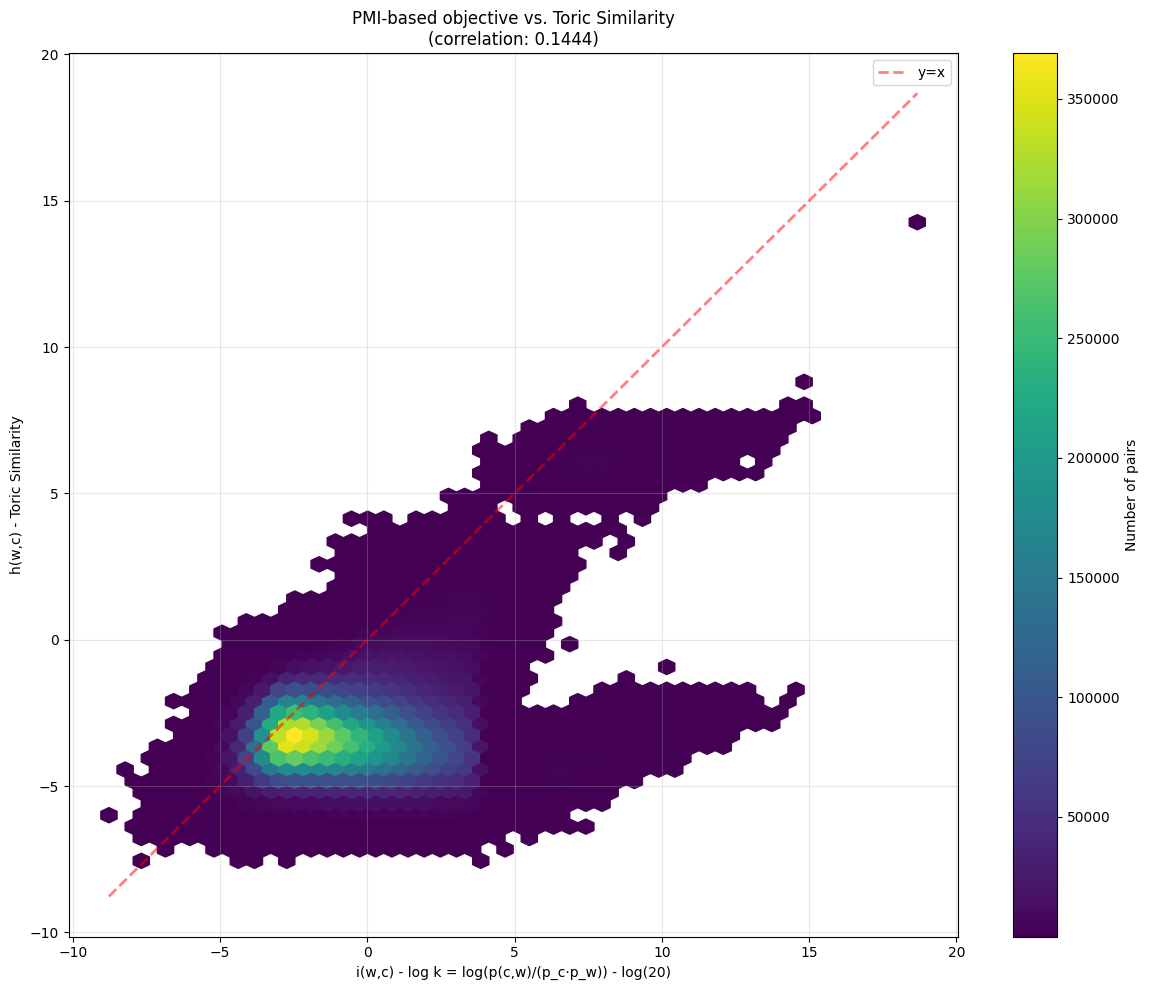

In [ ]:
# Convert e^(ln k + PMI) to PMI - ln k for comparison
# pmi_based_values currently stores e^(ln k + PMI)
# We want: PMI - ln k = log(p(c,w)/(p_c*p_w)) - log k
k = 20
i_minus_logk = pmi_values - np.log(k)

# Plot PMI - log k vs. h(w,c)
plt.figure(figsize=(12, 10))

# Create 2D histogram / hexbin plot for better visualization with many points
plt.hexbin(i_minus_logk, toric_sim_values, gridsize=50, cmap='viridis', mincnt=1)
plt.colorbar(label='Number of pairs')

# Compute correlation
correlation = np.corrcoef(i_minus_logk, toric_sim_values)[0, 1]
print(f"Correlation: {correlation:.4f}")

# Add reference line for perfect correlation
min_val = min(i_minus_logk.min(), toric_sim_values.min())
max_val = max(i_minus_logk.max(), toric_sim_values.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, alpha=0.5, label='y=x')

plt.xlabel('i(w,c) - log k = log(p(c,w)/(p_c·p_w)) - log(20)')
plt.ylabel('h(w,c) - Toric Similarity')
plt.title(f'PMI-based objective vs. Toric Similarity\n(correlation: {correlation:.4f})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
i_minus_logk.shape

torch.Size([20188508])

In [ ]:
# Print statistics
m = 20
i_minus_logk = np.array(i_minus_logk)
print(f"\nStatistics:")
print(f"  PMI - log k: mean={i_minus_logk.mean():.4f}, std={i_minus_logk.std():.4f}")
print(f"  h(w,c): mean={toric_sim_values.mean():.4f}, std={toric_sim_values.std():.4f}")
print(f"  Pearson correlation: {correlation:.4f}")

# Show some example pairs with high and low values
print(f"\nTop 5 pairs by PMI - log k:")
top_pmi_idx = np.argsort(i_minus_logk)[-m:][::-1]

for idx in top_pmi_idx:
    w, c = pair_words[idx]
    print(f"  ({w}, {c}): PMI-log k={i_minus_logk[idx]:.4f}, h(w,c)={toric_sim_values[idx]:.4f}")

print(f"\nTop {m} pairs by toric similarity:")
top_h_idx = np.argsort(toric_sim_values)[-m:][::-1]
for idx in top_h_idx:
    w, c = pair_words[idx]
    print(f"  ({w}, {c}): PMI-log k={i_minus_logk[idx]:.4f}, h(w,c)={toric_sim_values[idx]:.4f}")


In [ ]:
# Print statistics
m = 20
i_minus_logk = np.array(i_minus_logk)
print(f"\nStatistics:")
print(f"  PMI - log k: mean={i_minus_logk.mean():.4f}, std={i_minus_logk.std():.4f}")
print(f"  h(w,c): mean={toric_sim_values.mean():.4f}, std={toric_sim_values.std():.4f}")
print(f"  Pearson correlation: {correlation:.4f}")

# Show some example pairs with high and low values
print(f"\nTop {m} pairs by PMI - log k:")
top_pmi_idx = np.argsort(i_minus_logk)[::-1]
# filter out pairs with U in them
top_pmi_idx = [idx for idx in top_pmi_idx if 'UNK' not in pair_words[idx][0] and 'UNK' not in pair_words[idx][1]]
top_pmi_idx = top_pmi_idx[:m]

for idx in top_pmi_idx:
    w, c = pair_words[idx]
    print(f"  ({w}, {c}): PMI-log k={i_minus_logk[idx]:.4f}, h(w,c)={toric_sim_values[idx]:.4f}")

print(f"\nTop {m} pairs by toric similarity:")
top_h_idx = np.argsort(toric_sim_values)[::-1]
# filter out pairs with U in them
top_h_idx = [idx for idx in top_h_idx if 'UNK' not in pair_words[idx][0] and 'UNK' not in pair_words[idx][1]]
top_h_idx = top_h_idx[:m]

for idx in top_h_idx:
    w, c = pair_words[idx]
    print(f"  ({w}, {c}): PMI-log k={i_minus_logk[idx]:.4f}, h(w,c)={toric_sim_values[idx]:.4f}")



Statistics:
  PMI - log k: mean=-0.7638, std=2.0652
  h(w,c): mean=-3.2715, std=1.1701
  Pearson correlation: 0.1444

Top 20 pairs by PMI - log k:


  (Â, Â): PMI-log k=9.1939, h(w,c)=4.0193
  (■, ■): PMI-log k=8.7866, h(w,c)=3.3910
  (.........., ..........): PMI-log k=8.4894, h(w,c)=3.7138
  (-110, -110): PMI-log k=8.3995, h(w,c)=2.9484
  (0.0%, 0.0%): PMI-log k=7.7585, h(w,c)=3.7194
  (0.00, 0.00): PMI-log k=7.6813, h(w,c)=3.5661
  (HF, HF): PMI-log k=7.5364, h(w,c)=3.6306
  (Opp, Opp): PMI-log k=7.2549, h(w,c)=3.3478
  (filler, filler): PMI-log k=7.1577, h(w,c)=3.3728
  (__, __): PMI-log k=7.1263, h(w,c)=2.8849
  (XX, XX): PMI-log k=7.1246, h(w,c)=2.6565
  (★, ★): PMI-log k=7.1180, h(w,c)=3.6445
  (│, │): PMI-log k=7.0616, h(w,c)=2.9968
  (_, _): PMI-log k=7.0566, h(w,c)=3.5886
  (00, 00): PMI-log k=7.0455, h(w,c)=3.2323
  (NS, NS): PMI-log k=7.0335, h(w,c)=3.2860
  (£5.99, €6.99): PMI-log k=6.9570, h(w,c)=2.6661
  (<<, cout): PMI-log k=6.9170, h(w,c)=3.2196
  (<<, <<): PMI-log k=6.8916, h(w,c)=2.8649
  (-1, -1): PMI-log k=6.8787, h(w,c)=2.9707

Top 20 pairs by toric similarity:
  (Player, Player): PMI-log k=4.2588, h(w,c)=5.08

In [ ]:
sum_cosine_diff('the', 'woman')

/tmp/ipykernel_211674/798041297.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ivec = t.tensor(idx2ivec[word1_idx])
/tmp/ipykernel_211674/798041297.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ovec = t.tensor(idx2ovec[word2_idx])


tensor(-3.0334, device='cuda:0', grad_fn=<SumBackward1>)

In [ ]:
sum_cosine_diff('Low', 'Low')

/tmp/ipykernel_211674/798041297.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ivec = t.tensor(idx2ivec[word1_idx])
/tmp/ipykernel_211674/798041297.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ovec = t.tensor(idx2ovec[word2_idx])


tensor(4.1288, device='cuda:0', grad_fn=<SumBackward1>)

/tmp/ipykernel_211674/798041297.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ivecs = t.stack([t.tensor(idx2ivec[word]) for word in word1_idx])
/tmp/ipykernel_211674/798041297.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ovecs = t.stack([t.tensor(idx2ovec[word]) for word in word2_idx])


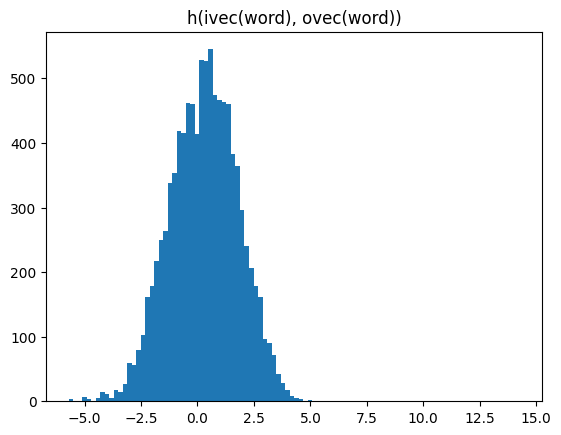

In [ ]:
# correlation between ivec and ovec for the k most common words
k = 10000
top_ivecs = list(range(k))
top_ovecs = list(range(k))

self_corrs = batch_sum_cosine_diff(top_ivecs, top_ovecs)
plt.hist(self_corrs.cpu().detach().numpy(), bins=100)

plt.title('h(ivec(word), ovec(word))')

in_context_h = toric_sim_values[:k]

in_context_pmi = 

plt.show()


In [ ]:
# correlation between ivec and ovec for the k most common words
k = 10000
top_ivecs = list(range(k))
top_ovecs = list(range(k))

corrs = batch_sum_cosine_diff(top_ivecs, top_ovecs)
plt.hist(corrs.cpu().detach().numpy(), bins=100)

plt.title('h(ivec(word), ovec(word))')
plt.show()


In [ ]:
# correlation between ivec and ovec for the k most common words
k = 10000
top_ivecs = list(range(k))
top_ovecs = list(range(k))

corrs = batch_sum_cosine_diff(top_ivecs, top_ovecs)
print(corrs.shape)

torch.Size([10000])


/tmp/ipykernel_211674/798041297.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ivecs = t.stack([t.tensor(idx2ivec[word]) for word in word1_idx])
/tmp/ipykernel_211674/798041297.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ovecs = t.stack([t.tensor(idx2ovec[word]) for word in word2_idx])


In [ ]:
plt.hist(corrs.cpu().detach().numpy(), bins=100)
plt.show()

In [ ]:
word2ivec['hi'][:10], word2ovec['hi'][:10]

(tensor([ 0.3425, -0.2780,  1.2337,  0.2442,  0.3768,  1.7556,  0.3222, -0.5581,
         -0.0709,  1.7206], device='cuda:0'),
 tensor([-2.0316, -0.7658,  1.0221, -0.8849, -2.1616,  1.3322, -0.6243, -2.5983,
         -0.3486, -0.3586], device='cuda:0'))

In [ ]:
word2ivec['hi'][486], word2ovec['hi'][486]

(tensor(0.0425, device='cuda:0'), tensor(-0.9905, device='cuda:0'))

In [ ]:
t.cos(t.pi * (word2ivec['hi'][486] - word2ovec['hi'][486]))

tensor(-0.9946, device='cuda:0')

In [ ]:
word2ivec['Low'][:10], word2ovec['Low'][:10]

(tensor([-0.5696, -1.0314,  0.9062,  0.9300, -0.1041,  0.9612, -0.1702, -1.0368,
          0.4238, -1.0319], device='cuda:0'),
 tensor([ 1.4150,  1.5975,  1.0987,  2.0837,  0.1619, -0.8640, -0.5213,  0.5846,
          0.2257, -0.5932], device='cuda:0'))

In [ ]:
word2ivec['Low'][486], word2ovec['Low'][486]

(tensor(0.0133, device='cuda:0'), tensor(-1.0141, device='cuda:0'))

In [ ]:
t.cos(t.pi * (word2ivec['Low'][486] - word2ovec['Low'][486]))

tensor(-0.9963, device='cuda:0')

torch.Size([512])


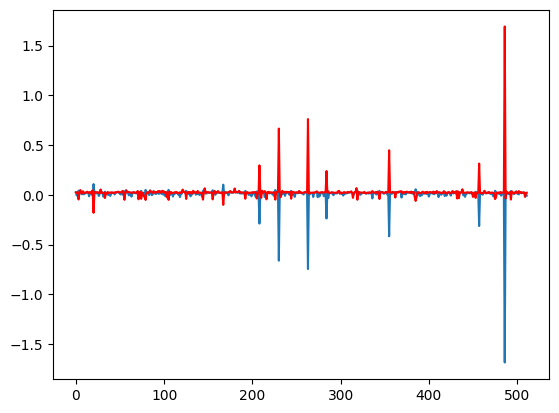

In [ ]:
ivec_low = word2ivec['Low']
ovec_low = word2ovec['Low']

# pts = t.cos(t.pi * (ivec_low - ovec_low))
pts = coord_weights * t.cos(t.pi * (ivec_low - ovec_low))
print(pts.shape)
pts = pts.cpu().detach().numpy()

# plot of coord_weights * cos(pi*(ivec_low[i] - ovec_low[i]))
plt.plot(range(512), pts)

plt.plot(range(512), coord_weights.cpu().detach().numpy(), 'r')

plt.show()

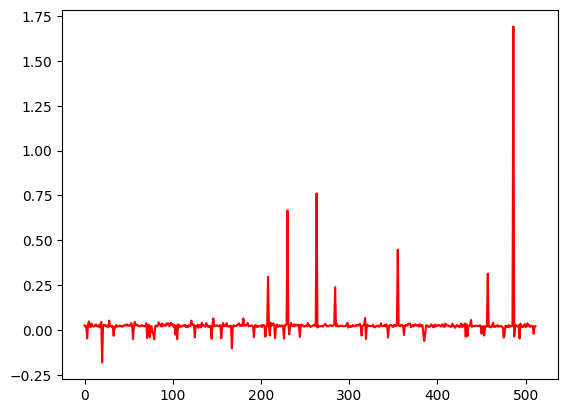

In [ ]:
# plot coord_weights on top of the plot



In [ ]:
t.argmax(t.tensor(pts)), t.argmin(t.tensor(pts))

(tensor(20), tensor(486))

In [ ]:
pts[486]

np.float32(-1.6863923)

In [ ]:
pts[20]

np.float32(0.107460685)

In [ ]:
sum(pts[:486])

np.float32(5.3695803)

In [ ]:
sum(pts)

np.float32(4.1288185)

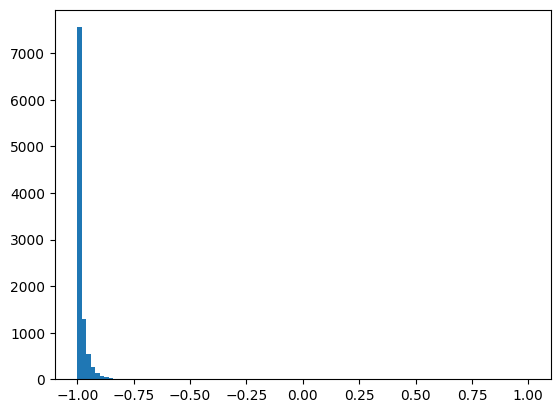

In [ ]:
idx = 486
coords = []

for i in range(10000):
    x = t.cos(t.pi * (idx2ivec[i][idx] - idx2ovec[i][idx]))
    x = x.cpu().detach().numpy().item()
    coords.append(x)

plt.hist(coords, bins=100)
plt.show()

In [ ]:
# Investigate the baseline similarity
# Compute h(w,c) for random unrelated word pairs
import random
random.seed(42)

random_pairs = []
random_sims = []
all_words_list = list(embeds.keys())

for _ in range(10000):
    w1, w2 = random.sample(all_words_list, 2)
    sim = sum_cosine_diff(embeds[w1], embeds[w2]).item()
    random_sims.append(sim)
    random_pairs.append((w1, w2))

random_sims = np.array(random_sims)
print(f"Random word pair similarities:")
print(f"  Mean: {random_sims.mean():.4f}")
print(f"  Std: {random_sims.std():.4f}")
print(f"  Min: {random_sims.min():.4f}")
print(f"  Max: {random_sims.max():.4f}")

# Compare to self-similarity (should be max)
self_sim = sum_cosine_diff(embeds['man'], embeds['man']).item()
print(f"\nSelf-similarity (max possible): {self_sim:.4f}")

# The issue: h(w,c) = sum(coord_weights * cos(π(w-c)))
# For random w,c, cos(π(w-c)) doesn't average to 0 due to coord_weights bias
print(f"\nMean coord_weights: {coord_weights.mean().item():.4f}")
print(f"This creates a positive baseline even for unrelated pairs!")


Random word pair similarities:
  Mean: 4.3328
  Std: 0.6268
  Min: 1.7900
  Max: 8.2373

Self-similarity (max possible): 14.2646

Mean coord_weights: 0.0279
This creates a positive baseline even for unrelated pairs!


Correlation (centered): 0.4063
Original correlation: 0.3019


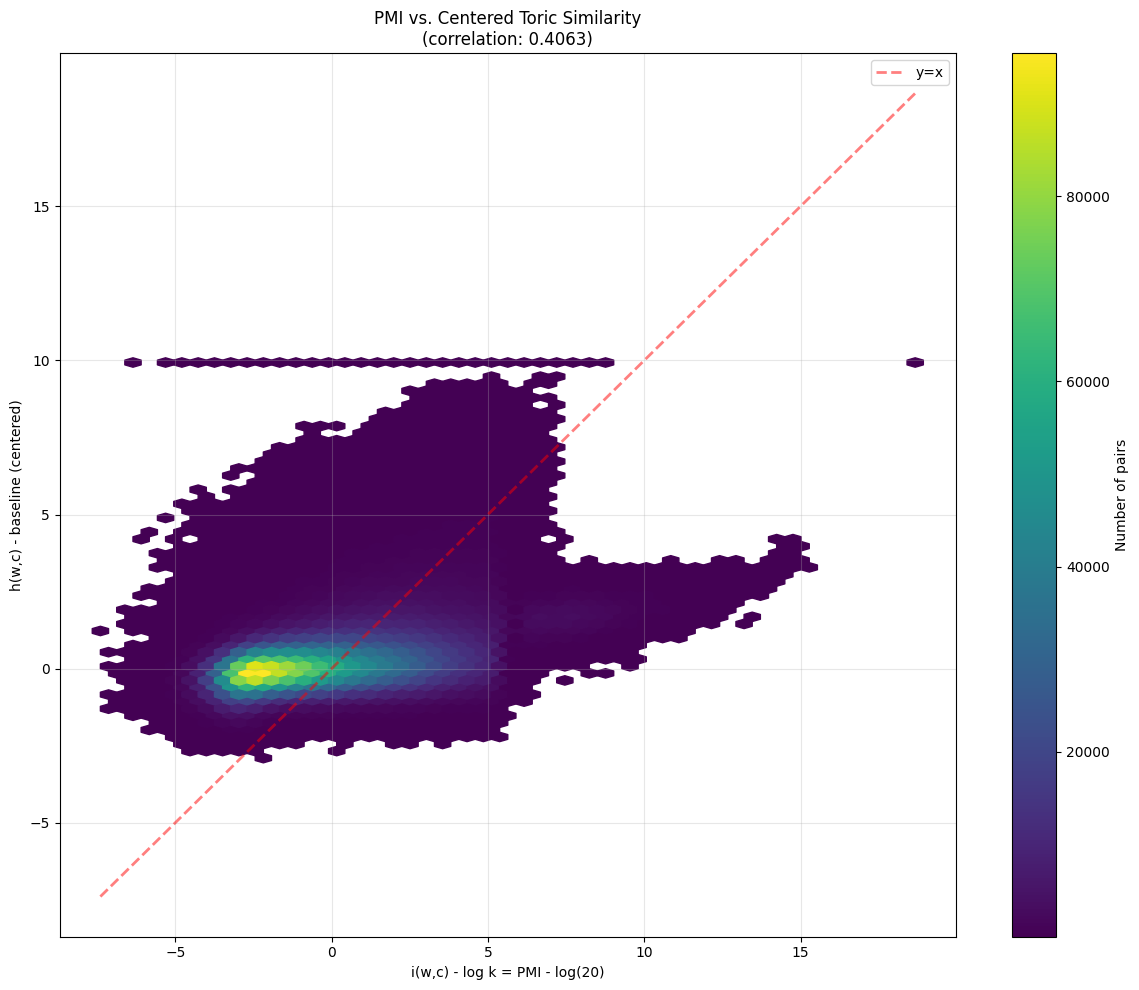


Centered h(w,c) statistics:
  Mean: 0.2162
  Std: 0.9171


In [ ]:
# Try centering h(w,c) by subtracting the baseline
# Use the mean of random pairs as the baseline
baseline = random_sims.mean()
toric_sim_centered = toric_sim_values - baseline

# Replot with centered toric similarity
plt.figure(figsize=(12, 10))
plt.hexbin(i_minus_logk, toric_sim_centered, gridsize=50, cmap='viridis', mincnt=1)
plt.colorbar(label='Number of pairs')

# Compute correlation with centered values
correlation_centered = np.corrcoef(i_minus_logk, toric_sim_centered)[0, 1]
print(f"Correlation (centered): {correlation_centered:.4f}")
print(f"Original correlation: {correlation:.4f}")

# Add reference line for perfect correlation
min_val = min(i_minus_logk.min(), toric_sim_centered.min())
max_val = max(i_minus_logk.max(), toric_sim_centered.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, alpha=0.5, label='y=x')

plt.xlabel('i(w,c) - log k = PMI - log(20)')
plt.ylabel('h(w,c) - baseline (centered)')
plt.title(f'PMI vs. Centered Toric Similarity\n(correlation: {correlation_centered:.4f})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nCentered h(w,c) statistics:")
print(f"  Mean: {toric_sim_centered.mean():.4f}")
print(f"  Std: {toric_sim_centered.std():.4f}")


compare to real

In [ ]:
# Load embeddings from idx2vec.dat
real_idx2vec_path = "runs/R512-train-window-10/idx2vec.dat"
real_idx2vec = pickle.load(open(real_idx2vec_path, 'rb'))
print(f"Loaded real_idx2vec with {len(real_idx2vec)} embeddings")
print(f"Embedding dimension: {real_idx2vec[0].shape if len(real_idx2vec) > 0 else 'N/A'}")

# Create word-to-embedding dictionary for convenience
real_embeds = {words[idx]: real_idx2vec[idx] for idx in range(len(words))}
print(f"Created embeds dict with {len(real_embeds)} entries")


Loaded real_idx2vec with 50304 embeddings
Embedding dimension: (512,)
Created embeds dict with 50304 entries


In [ ]:
def dot(
    x: t.Tensor,  # [E]
    y: t.Tensor,  # [E]
) -> t.Tensor:
    x = t.tensor(x)
    y = t.tensor(y)
    # dot product
    # print(x @ y)
    return x @ y

In [ ]:
# Compute PMI and toric similarity for sampled pairs
k = 20  # Number of negative samples in SGNS

real_sim_values = []   # h(w,c)

total_centers = sum(sample_center_counts.values())
assert total_centers == sample_size
total_contexts = sum(sample_context_counts.values())
assert total_contexts == 10 * sample_size

print("Computing PMI and real similarities for unique pairs...")
unique_pairs = list(sample_pair_counts.items())
for idx_num, ((center_idx, context_idx), count_pair) in enumerate(unique_pairs):
    if idx_num % 10000 == 0:
        print(f"  Processed {idx_num:,}/{len(unique_pairs):,} unique pairs", end='\r')
    
    center_word = words[center_idx]
    context_word = words[context_idx]
    
    # Compute toric similarity h(w,c)
    if center_word in real_embeds and context_word in real_embeds:
        h_wc = dot(real_embeds[center_word], real_embeds[context_word]).item()
        
        real_sim_values.append(h_wc)

print(f"\nComputed {len(i_values):,} valid pairs")

real_sim_values = np.array(real_sim_values)

Computing PMI and real similarities for unique pairs...


  Processed 6,000,000/6,004,290 unique pairs
Computed 6,004,290 valid pairs


Correlation: 0.3019


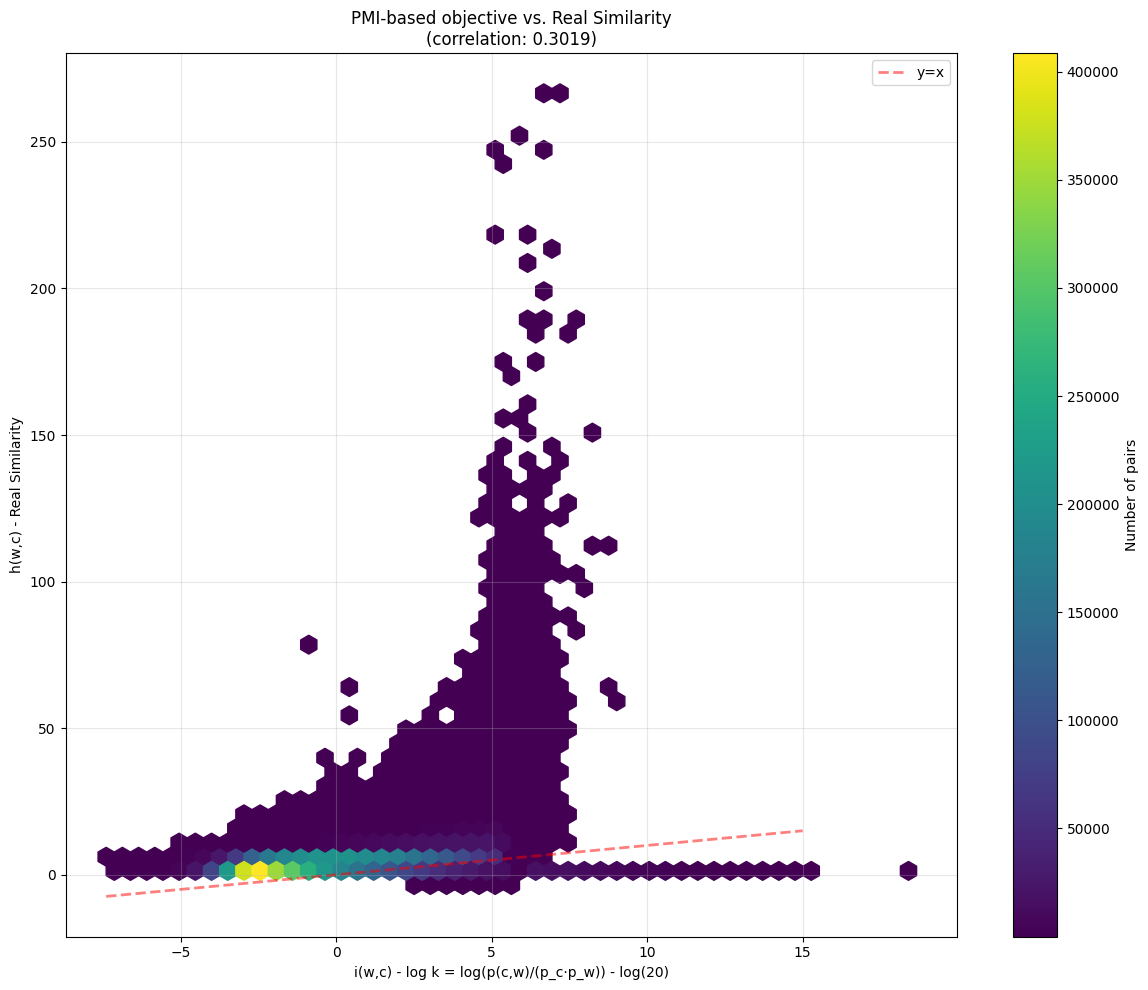


Statistics:
  PMI - log k: mean=-0.0999, std=2.5025
  h(w,c): mean=4.0569, std=2.3895
  Pearson correlation: 0.3019

Top 5 pairs by PMI - log k:
  (<UNK>, <UNK>): PMI-log k=18.6653, h(w,c)=0.0000
  (The, <UNK>): PMI-log k=15.2558, h(w,c)=0.0000
  (the, <UNK>): PMI-log k=14.9323, h(w,c)=0.0000
  (of, <UNK>): PMI-log k=14.8698, h(w,c)=0.0000
  (and, <UNK>): PMI-log k=14.8626, h(w,c)=0.0000

Top 5 pairs by real similarity:
  (€6.99, £5.99): PMI-log k=6.7102, h(w,c)=266.5820
  (£5.99, €6.99): PMI-log k=7.2980, h(w,c)=266.5820
  (window._taboola, window._taboola): PMI-log k=6.1062, h(w,c)=253.1083
  ($0.18, €0.18): PMI-log k=6.9223, h(w,c)=248.9492
  (€0.18, $0.18): PMI-log k=5.3131, h(w,c)=248.9492


In [ ]:
# Convert e^(ln k + PMI) to PMI - ln k for comparison
# pmi_based_values currently stores e^(ln k + PMI)
# We want: PMI - ln k = log(p(c,w)/(p_c*p_w)) - log k

# Plot PMI - log k vs. h(w,c)
plt.figure(figsize=(12, 10))

# Create 2D histogram / hexbin plot for better visualization with many points
plt.hexbin(i_minus_logk, real_sim_values, gridsize=50, cmap='viridis', mincnt=1)
plt.colorbar(label='Number of pairs')

# Compute correlation
correlation = np.corrcoef(i_minus_logk, real_sim_values)[0, 1]
print(f"Correlation: {correlation:.4f}")

# Add reference line for perfect correlation
min_val = min(i_minus_logk.min(), real_sim_values.min())
max_val = max(i_minus_logk.max(), real_sim_values.max())
max_val = min(max_val, 15)
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, alpha=0.5, label='y=x')

plt.xlabel('i(w,c) - log k = log(p(c,w)/(p_c·p_w)) - log(20)')
plt.ylabel('h(w,c) - Real Similarity')
plt.title(f'PMI-based objective vs. Real Similarity\n(correlation: {correlation:.4f})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print statistics
print(f"\nStatistics:")
print(f"  PMI - log k: mean={i_minus_logk.mean():.4f}, std={i_minus_logk.std():.4f}")
print(f"  h(w,c): mean={real_sim_values.mean():.4f}, std={real_sim_values.std():.4f}")
print(f"  Pearson correlation: {correlation:.4f}")

# Show some example pairs with high and low values
print(f"\nTop 5 pairs by PMI - log k:")
top_pmi_idx = np.argsort(i_minus_logk)[-5:][::-1]
for idx in top_pmi_idx:
    w, c = pair_words[idx]
    print(f"  ({w}, {c}): PMI-log k={i_minus_logk[idx]:.4f}, h(w,c)={real_sim_values[idx]:.4f}")

print(f"\nTop 5 pairs by real similarity:")
top_h_idx = np.argsort(real_sim_values)[-5:][::-1]
for idx in top_h_idx:
    w, c = pair_words[idx]
    print(f"  ({w}, {c}): PMI-log k={i_minus_logk[idx]:.4f}, h(w,c)={real_sim_values[idx]:.4f}")


In [ ]:
# Compute gender direction differences and plot correlation
def check_correlation(
    embeds=embeds,
    man="man",
    woman="woman",
    king="king",
    queen="queen",
    interesting_words = ['man', 'woman', 'king', 'queen', 'boy', 'girl', 'he', 'she', 
                        'father', 'mother', 'son', 'daughter', 'brother', 'sister']
):
    k_q_vals = []  # king - queen direction
    m_w_vals = []  # man - woman direction
    words_list = []

    for word, embed in embeds.items():
        k_q = sum_cosine_diff(embed, embeds[king]).item() - sum_cosine_diff(embed, embeds[queen]).item()
        m_w = sum_cosine_diff(embed, embeds[man]).item() - sum_cosine_diff(embed, embeds[woman]).item()
        k_q_vals.append(k_q)
        m_w_vals.append(m_w)
        words_list.append(word)

    k_q_vals = np.array(k_q_vals)
    m_w_vals = np.array(m_w_vals)

    # Compute correlation
    correlation = np.corrcoef(k_q_vals, m_w_vals)[0, 1]
    print(f"Correlation between ({king}-{queen}) and ({man}-{woman}) directions: {correlation:.4f}")

    # Create scatter plot
    plt.figure(figsize=(12, 10))
    plt.scatter(k_q_vals, m_w_vals, alpha=0.3, s=5)

    # Add reference line y=x
    min_val = min(k_q_vals.min(), m_w_vals.min())
    max_val = max(k_q_vals.max(), m_w_vals.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='y=x (perfect correlation)')

    # Annotate some interesting words
    
    for word in interesting_words:
        if word in embeds:
            idx = words_list.index(word)
            plt.annotate(word, (k_q_vals[idx], m_w_vals[idx]), 
                        fontsize=10, alpha=0.8, 
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.5))

    plt.xlabel(f'sim(word, {king}) - sim(word, {queen})')
    plt.ylabel(f'sim(word, {man}) - sim(word, {woman})')
    plt.title(f'Gender Direction Correlation (r={correlation:.4f})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.show()

    print(f"\nWords most aligned with both gender directions (high {king}-{queen} and {man}-{woman}):")
    combined = k_q_vals + m_w_vals
    top_idx = np.argsort(combined)[-10:][::-1]
    for idx in top_idx:
        print(f"  {words_list[idx]}: {king}-{queen}={k_q_vals[idx]:.3f}, {man}-{woman}={m_w_vals[idx]:.3f}")


Correlation between (king-queen) and (man-woman) directions: 0.4597


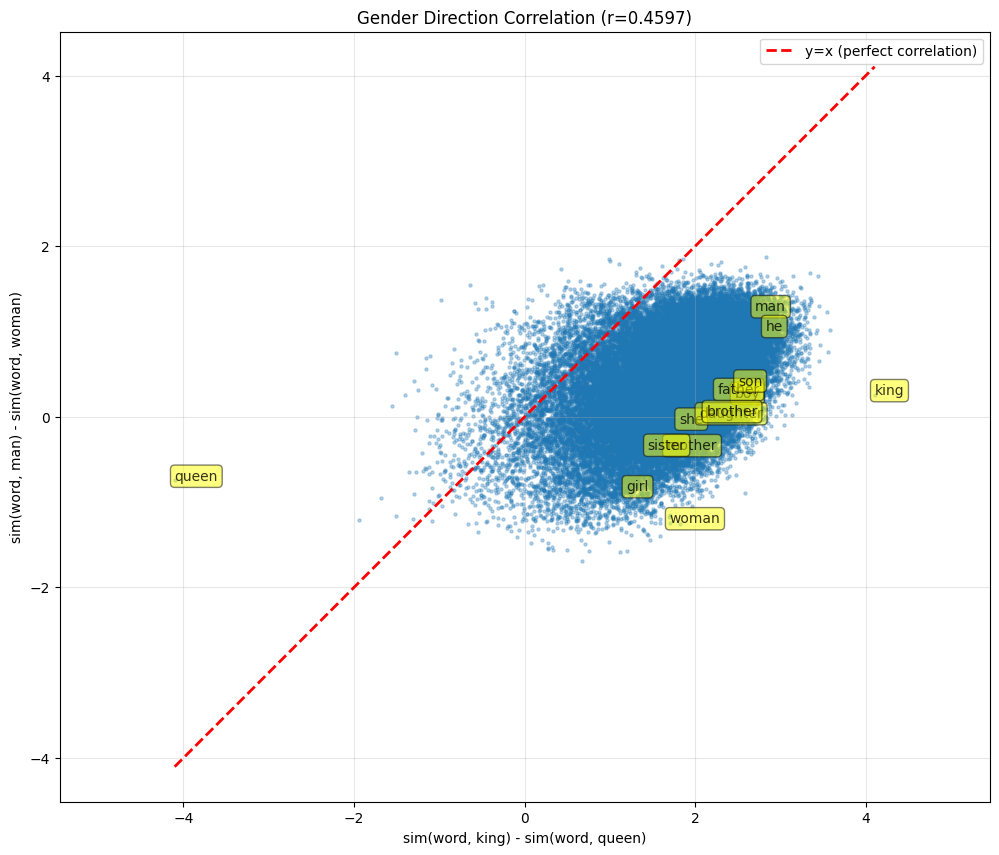


Words most aligned with both gender directions (high king-queen and man-woman):
  Benny: king-queen=3.439, man-woman=1.654
  underlies: king-queen=3.346, man-woman=1.688
  AD: king-queen=3.145, man-woman=1.651
  Ibn: king-queen=3.549, man-woman=1.228
  63,: king-queen=3.245, man-woman=1.514
  Gideon: king-queen=3.228, man-woman=1.521
  inscribed: king-queen=3.451, man-woman=1.296
  Fritz: king-queen=3.343, man-woman=1.397
  Shipping: king-queen=3.363, man-woman=1.365
  71%: king-queen=3.358, man-woman=1.344


In [ ]:
check_correlation(real_embeds)

Correlation between (dad-mom) and (man-woman) directions: 0.1398


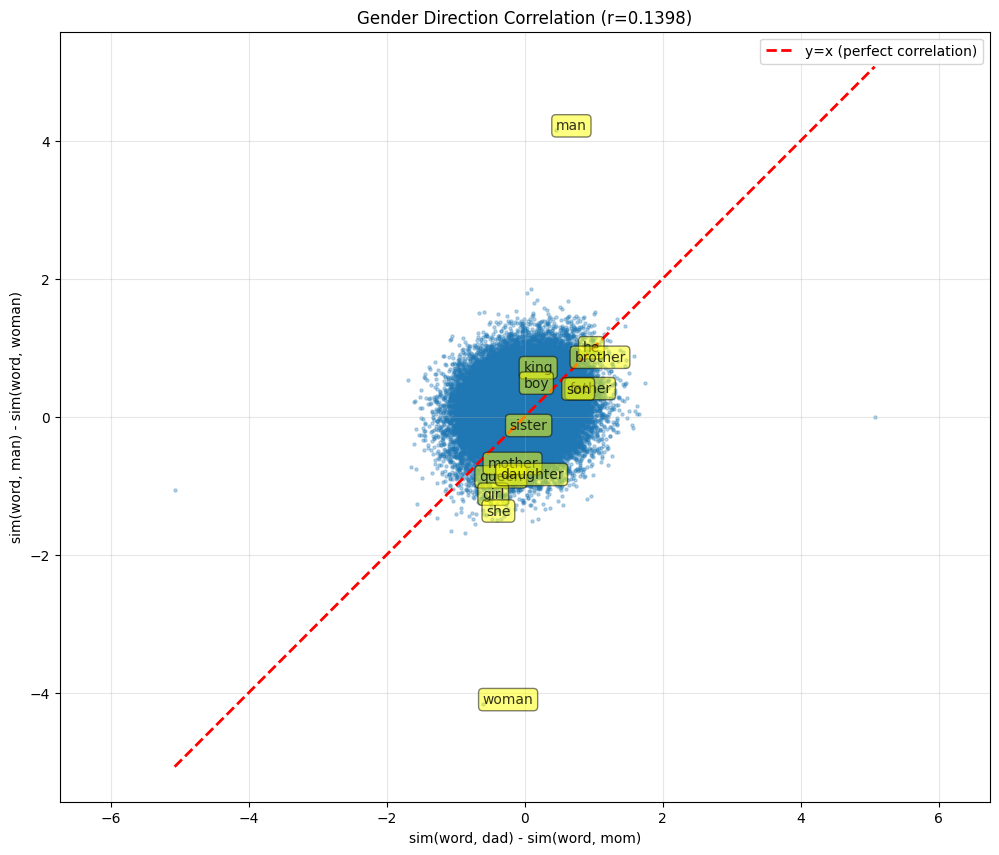


Words most aligned with both gender directions (high dad-mom and man-woman):
  dad: dad-mom=5.072, man-woman=0.000
  man: dad-mom=0.454, man-woman=4.157
  Munich: dad-mom=1.457, man-woman=1.318
  Dorsey: dad-mom=1.339, man-woman=1.420
  Kidd: dad-mom=1.013, man-woman=1.512
  Moyes: dad-mom=1.212, man-woman=1.280
  Anfield: dad-mom=1.001, man-woman=1.485
  Erich: dad-mom=1.589, man-woman=0.875
  Middlesbrough: dad-mom=1.431, man-woman=0.938
  Salah: dad-mom=1.376, man-woman=0.972


In [ ]:
check_correlation(
    man="man",
    woman="woman",
    king="dad",
    queen="mom",
    interesting_words = ['man', 'woman', 'king', 'queen', 'boy', 'girl', 'he', 'she', 
                        'father', 'mother', 'son', 'daughter', 'brother', 'sister']
)